# Access and visualization of EO Data on the Cloud (COGS)

**Purpose** : 
>Connect to an EO data catalog by using a [SpatioTemporal Asset Catalog (STAC)](https://stacspec.org/) client in Python.\
>Search for data products for a specific region and time period.\
>Display the boundaries of the available scenes\
>Get an overview of the actual images\
>Save band image.

<hr/> 

## 1-import required libraries

In [1]:
# Import necessary packages
import os 
import cv2
from datetime import date
import json
import itertools
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sentinelhub import pixel_to_utm, utm_to_pixel
import utm
import pandas as pd
from shapely.geometry import box
from rasterio.mask import mask
from pystac_client import Client
import shapely.geometry
import shapely.wkt
import folium
import shapely.geometry
#from odc.algo import to_rgba
import earthpy.spatial as es
import earthpy.plot as ep
import rioxarray
#import contextily as ctx 

/Users/noeliaotero/opt/anaconda3/envs/pyRem/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<hr/> 

## 2-Set the AOI

In [2]:
#Set the path to data
aoi_dir = "/Users/noeliaotero/Documents/douala-chapter-automatic-land-use/src/data/aoi"
aoi_file = "littoral_outline.geojson"
aoi_path = os.path.join(aoi_dir , aoi_file )

In [3]:
pwd

'/Users/noeliaotero/Documents/Geo_analysis'

In [4]:
def get_bounds_of_AoI(obj_aoi, offset):
    
    aoi = gpd.read_file(obj_aoi)
    
    bounds = aoi.total_bounds
    #offset = 1/60  #200m in degree
    # Extend the bounding box by 200 m
    minx, miny = bounds[0]-offset, bounds[1]-offset
    maxx, maxy = bounds[2]+offset, bounds[3]+offset

    bbox = box(minx, miny, maxx, maxy)
    
    print(bbox)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

    
    return geo 

In [5]:
#offset = 1/60  #200m in degree
bbx = get_bounds_of_AoI(aoi_path, 1/60)

POLYGON ((11.094414006666668 3.243667343333333, 11.094414006666668 5.351516026666666, 9.319134458233293 5.351516026666666, 9.319134458233293 3.243667343333333, 11.094414006666668 3.243667343333333))


In [6]:
bbx.explore()

<hr/> 

## 3-Search a STAC catalog

In [7]:
# STAC API endpoint
api_url = "https://earth-search.aws.element84.com/v0"
client = Client.open(api_url)
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A, COGs

In [8]:
values = []
for i in range(len(bbx.total_bounds)):
    values.append(bbx.total_bounds[i])
keys = ["lonmin", "latmin", "lonmax", "latmax"]  
geometry = dict(zip(keys, values))

In [9]:
time =  ["2023-01-01", "2023-01-15"]
search = client.search(
    collections=[collection],
    bbox= [ geometry["lonmin"], geometry["latmin"],  geometry["lonmax"], geometry["latmax"]],
    datetime = ["2023-01-01", "2023-01-15"],
    #limit=100,
    query=["eo:cloud_cover<0.01"]
)
print(search.matched())

2


In [10]:
items = search.get_all_items()
items.save_object("search.json")

In [16]:
items

<hr/> 

## 4-Access the assets

In [11]:
assets = items[0].assets  # first item's asset dictionary
print(assets.keys())

dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])


In [12]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

thumbnail: Thumbnail
overview: True color image
info: Original JSON metadata
metadata: Original XML metadata
visual: True color image
B01: Band 1 (coastal)
B02: Band 2 (blue)
B03: Band 3 (green)
B04: Band 4 (red)
B05: Band 5
B06: Band 6
B07: Band 7
B08: Band 8 (nir)
B8A: Band 8A
B09: Band 9
B11: Band 11 (swir16)
B12: Band 12 (swir22)
AOT: Aerosol Optical Thickness (AOT)
WVP: Water Vapour (WVP)
SCL: Scene Classification Map (SCL)


In [13]:
visual_href = assets["visual"].href
visual = rioxarray.open_rasterio(visual_href)

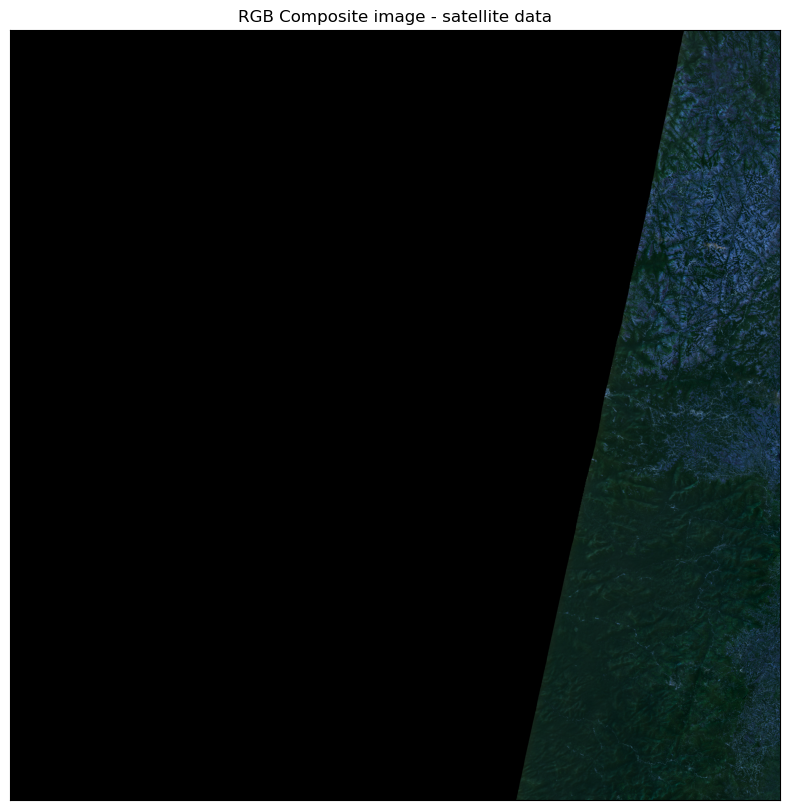

In [14]:
#Plot the RGB composite
ep.plot_rgb(visual.values,
            rgb=[2, 1, 0],
            title="RGB Composite image - satellite data")
plt.show()

In [16]:
visual.shape

(3, 10980, 10980)

In [ ]:
#Save RGB to Disk
#visual.rio.to_raster("visual00.tif")

In [17]:
#Access band 2
b02_href = assets["B02"].href
b02 = rioxarray.open_rasterio(b02_href)
#b02.rio.to_raster("B02.tif")

In [18]:
b02.shape

(1, 10980, 10980)

In [19]:
#Access band 3
b03_href = assets["B03"].href
b03 = rioxarray.open_rasterio(b03_href)
#b03.rio.to_raster("B03.tif")

In [20]:
#Access Band 4
b04_href = assets["B04"].href
b04 = rioxarray.open_rasterio(b04_href)
#b04.rio.to_raster("B04.tif")

In [21]:
# Acces SCL: Scene Classification Map (SCL)
bscl_href = assets["SCL"].href
bscl = rioxarray.open_rasterio(bscl_href)
#bscl.rio.to_raster("SCL.tif")

In [22]:
#Access Band 8
b08_href = assets["B08"].href
b08 = rioxarray.open_rasterio(b08_href)
#b08.rio.to_raster("B08.tif")

In [25]:
print('shape b08', b02.shape)

shape b08 (1, 10980, 10980)


In [28]:
import xarray as xr

In [34]:
# stack all bands
ds = np.vstack([b04, b03, b02, b08])

In [36]:
print(ds.shape)

(4, 10980, 10980)


In [41]:
# Create xr.DataArray to write netcdf
df = xr.DataArray(ds, dims=['Bands','x','y'])

In [43]:
# Save to netcdf
PATH_ncdf = '/Users/noeliaotero/Documents/Geo_analysis/'
file_name = os.path.join(PATH_ncdf,"file_all_bands.nc")
df.to_netcdf(file_name)

In [44]:
# open again
xr.open_dataset(file_name)

<xarray.Dataset>
Dimensions:                        (Bands: 4, x: 10980, y: 10980)
Dimensions without coordinates: Bands, x, y
Data variables:
    __xarray_dataarray_variable__  (Bands, x, y) uint16 ...